**#Importing libraries**

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix
import tensorflow as tf
import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import dump,load
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

**#Read Dataset/Calculating weight**

In [2]:
df = pd.read_json("./Video_Games_5.json", lines=True)
num_overall_1 = df["overall"].value_counts()[1]
num_overall_2 = df["overall"].value_counts()[2]
num_overall_3 = df["overall"].value_counts()[3]
num_overall_4 = df["overall"].value_counts()[4]
num_overall_5 = df["overall"].value_counts()[5]
num_class_0 = num_overall_1 + num_overall_2
num_class_2 = num_overall_4 + num_overall_5
weight_0 = num_class_2 / num_class_0
weight_1 = num_class_2 / num_overall_3
bayes_weight=[0.4,0.4,0.2]
svm_rf_weight={0:weight_0, 1: weight_1, 2:4}

**#Creating classes**

In [3]:
df["sentiment"] = df["overall"].apply(
    lambda rating: 0 if rating <= 2 else (1 if rating == 3 else 2)
)

**#Preprocessing**

In [4]:

df.fillna({"reviewText": ""}, inplace=True)

df["reviewText"] = df["reviewText"].apply(lambda x: re.sub(r"\W", " ", str(x)))

stop_words = set(stopwords.words("english"))
df["reviewText"] = df["reviewText"].apply(
    lambda x: " ".join([word for word in word_tokenize(x) if word not in stop_words])
)

stemmer = PorterStemmer()
df["reviewText"] = df["reviewText"].apply(
    lambda x: " ".join([stemmer.stem(word) for word in word_tokenize(x)])
)

**#Vectorization**

In [5]:
vectorizer = TfidfVectorizer()
reviews_tfidf = vectorizer.fit_transform(df["reviewText"])

**#UnderSampling**

In [6]:
rus=RandomUnderSampler(random_state=42, sampling_strategy={2: 50000})
reviews_sampled, sentiments_sampled = rus.fit_resample(reviews_tfidf, df["sentiment"])

**#Splitting dataset**

In [7]:
reviews_train, reviews_test, sentiments_train, sentiments_test = train_test_split(
    reviews_sampled, sentiments_sampled, test_size=0.2, random_state=42
)

**#Random Forest Classifier**

In [ ]:
clf = RandomForestClassifier(n_estimators=300, max_depth=100, min_samples_leaf=5, min_samples_split=10, random_state=42, class_weight=svm_rf_weight)

clf.fit(reviews_train, sentiments_train)

dump(clf, 'random_forest_classifier_partition.joblib')
rf_loaded = load('random_forest_classifier_partition.joblib')

sentiments_pred = rf_loaded.predict(reviews_test)
train_accuracy = accuracy_score(sentiments_train, rf_loaded.predict(reviews_train))
test_accuracy = accuracy_score(sentiments_test, rf_loaded.predict(reviews_test))
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)
print(classification_report(sentiments_test, sentiments_pred))

cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**#SVM Classifier**

In [ ]:
clf = LinearSVC(dual=True, max_iter=10000, class_weight=svm_rf_weight)

clf.fit(reviews_train, sentiments_train)

dump(clf, 'svm_partition.joblib')
svm_loaded = load('svm.joblib')

sentiments_pred = clf.predict(reviews_test)
train_accuracy = accuracy_score(sentiments_train, clf.predict(reviews_train))
test_accuracy = accuracy_score(sentiments_test, clf.predict(reviews_test))
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)
print(classification_report(sentiments_test, sentiments_pred))

cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**#Multinomial Naive Bayes Classifier**

In [ ]:
clf = MultinomialNB(class_prior=bayes_weight)
clf.fit(reviews_train, sentiments_train)
dump(clf, "bayes_partition.joblib")

nb_loaded = load('bayes.joblib')
sentiments_pred = clf.predict(reviews_test)

print(classification_report(sentiments_test, sentiments_pred))

train_accuracy = accuracy_score(sentiments_train, clf.predict(reviews_train))
test_accuracy = accuracy_score(sentiments_test, clf.predict(reviews_test))
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**#WordCloud**

In [ ]:
positive_reviews = df[df['sentiment'] == 2]['reviewText'].str.cat(sep=' ')
wordcloud = WordCloud(background_color='white', max_words=200).generate(positive_reviews)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

negative_reviews = df[df['sentiment'] == 0]['reviewText'].str.cat(sep=' ')
wordcloud_negative = WordCloud(background_color='white', max_words=200, contour_color='red').generate(negative_reviews)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()

**#Metrics Graph**

In [ ]:
svm_loaded = load('svm_partition.joblib')
nb_loaded = load('bayes_partition.joblib')
precision_rf, recall_rf, fscore_rf, _ = score(sentiments_test, rf_loaded.predict(reviews_test), average='macro')

precision_svm, recall_svm, fscore_svm, _ = score(sentiments_test, svm_loaded.predict(reviews_test), average='macro')

precision_nb, recall_nb, fscore_nb, _ = score(sentiments_test, nb_loaded.predict(reviews_test), average='macro')

models = ['Random Forest', 'SVM', 'Naive Bayes']
precision_scores = [precision_rf, precision_svm, precision_nb]
recall_scores = [recall_rf, recall_svm, recall_nb]
fscore_scores = [fscore_rf, fscore_svm, fscore_nb]

x = np.arange(len(models))  
width = 0.25  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, fscore_scores, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()
plt.show()

**#Rete Neurale Fully Connected**

In [9]:
#reteneurale mia
input_size = reviews_tfidf.shape[1]

# Definizione della struttura della rete
input_layer = tf.keras.Input(shape=(input_size,))
hidden_layer = tf.keras.layers.Dense(72, activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(3, activation='softmax')(hidden_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compilazione del modello
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(reviews_train, sentiments_train, epochs=50, batch_size=256, shuffle=True)

Epoch 1/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.3464 - loss: 1.5629
Epoch 2/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3590 - loss: 1.0968
Epoch 3/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.3609 - loss: 1.0946
Epoch 4/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.3608 - loss: 1.0932
Epoch 5/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.3604 - loss: 1.0920
Epoch 6/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3648 - loss: 1.0899
Epoch 7/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3632 - loss: 1.0883
Epoch 8/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3657 - loss: 1.0860
Epoch 9/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3669 - loss: 1.0834
Epoch 10/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3691 - loss: 1.0805
Epoch 11/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.3721 - loss: 1.0767
Epoch 12/50
482/482 ━━━━━━━━━━

964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       0.37      0.91      0.53     10894
           1       0.32      0.05      0.08      9892
           2       0.53      0.14      0.22     10047

    accuracy                           0.38     30833
   macro avg       0.41      0.37      0.28     30833
weighted avg       0.41      0.38      0.29     30833


Accuracy: 0.38413388252845976


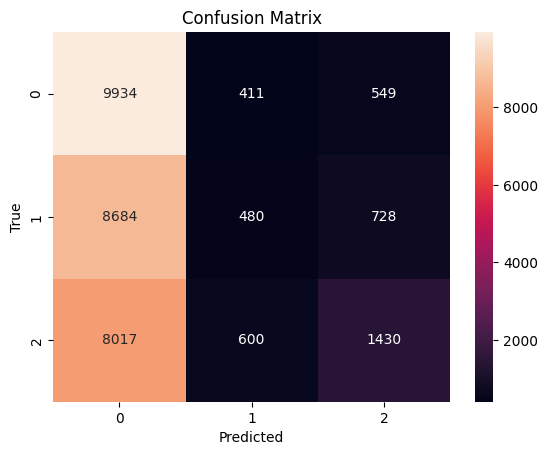

In [14]:
# Predizione con il modello addestrato
predictions = model.predict(reviews_test)

# Calcola le predizioni del modello come classi binarie
predicted_classes = predictions.argmax(axis=1)  # Ottiene l'indice della classe con probabilità più alta

real_labels = sentiments_test.astype(int)


print(classification_report(real_labels, predicted_classes))
print("\nAccuracy:", accuracy_score(real_labels, predicted_classes))

# Calcola la matrice di confusione
cm = confusion_matrix(real_labels, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**FCN With Dropout Layer**

In [11]:
# reteneurale mia + chatgpt
# Converti le matrici sparse in CSR (Compressed Sparse Row) per garantire la compatibilità con TensorFlow
reviews_train_csr = csr_matrix(reviews_train)
reviews_test_csr = csr_matrix(reviews_test)

# Miscele i dati
reviews_train_csr, sentiments_train_shuffle = shuffle(reviews_train_csr, sentiments_train)

# Crea il modello
model = tf.keras.Sequential([
    tf.keras.layers.Dense(72, activation='relu', input_shape=(reviews_train_csr.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compila il modello
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Addestra il modello
model.fit(
    reviews_train_csr, sentiments_train_shuffle, epochs=20, batch_size=256, shuffle=True
)

# Valuta il modello
loss, accuracy = model.evaluate(reviews_test_csr, sentiments_test)
print("Test Accuracy:", accuracy)

c:\Users\LorenzoStancato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.5750 - loss: 0.9135
Epoch 2/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.7186 - loss: 0.6763
Epoch 3/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.7546 - loss: 0.6110
Epoch 4/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.7840 - loss: 0.5533
Epoch 5/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.8069 - loss: 0.5024
Epoch 6/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.8273 - loss: 0.4550
Epoch 7/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.8450 - loss: 0.4144
Epoch 8/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.8575 - loss: 0.3827
Epoch 9/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.8706 - loss: 0.3524
Epoch 10/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.8792 - loss: 0.3269
Epoch 11/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.8841 - loss: 0.3151
Epoch 12/20
482/482 ━━━━━━━━━━

964/964 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     10894
           1       0.58      0.55      0.56      9892
           2       0.73      0.76      0.74     10047

    accuracy                           0.68     30833
   macro avg       0.67      0.68      0.67     30833
weighted avg       0.67      0.68      0.68     30833


Accuracy: 0.677488405280057


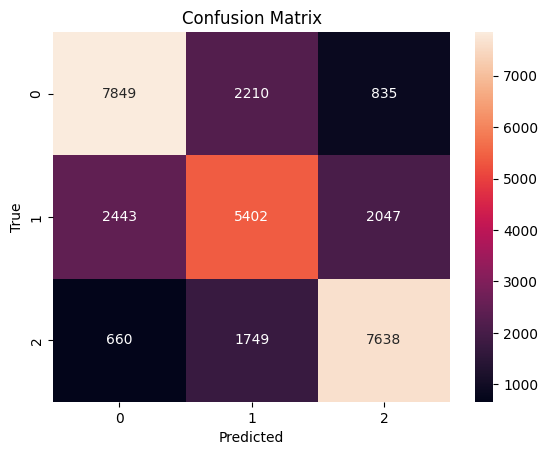

In [12]:
# Predizione con il modello addestrato
predictions = model.predict(reviews_test)

# Calcola le predizioni del modello come classi binarie
predicted_classes = predictions.argmax(axis=1)  # Ottiene l'indice della classe con probabilità più alta

real_labels = sentiments_test.astype(int)


print(classification_report(real_labels, predicted_classes))
print("\nAccuracy:", accuracy_score(real_labels, predicted_classes))

# Calcola la matrice di confusione
cm = confusion_matrix(real_labels, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**#1DCNN**

In [ ]:
# BEFORE STARTING CNN CODE
# DOWNLOAD glove.6B.200d.txt FROM THE FOLLOWING LINK AND PLACE IT IN THE SAME DIRECTORY AS THIS SCRIPT
# https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation?resource=download

In [8]:
def load_glove_vectors(file_path):
    word_vectors = {}
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            parts = line.split()
            word = parts[0]
            vector = np.array([float(val) for val in parts[1:]])
            word_vectors[word] = vector
    return word_vectors

glove_file_path = "./glove.6B.200d.txt"
glove_vectors = load_glove_vectors(glove_file_path)

vocab_size = len(glove_vectors)
embedding_dim = len(next(iter(glove_vectors.values())))
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {}
for i, (word, vector) in enumerate(glove_vectors.items()):
    embedding_matrix[i] = vector
    word_index[word] = i

In [10]:
modelCNN = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
        ),
        tf.keras.layers.Conv1D(64, 5, activation="relu"),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)

modelCNN.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


modelCNN.fit(
    reviews_train,
    sentiments_train,
    epochs=1,
    batch_size=32,
    validation_split=0.1,
)


# Valutazione del modello


loss, accuracy = modelCNN.evaluate(reviews_test, sentiments_test)

print("Test Accuracy:", accuracy)

3469/3469 ━━━━━━━━━━━━━━━━━━━━ 83440s 24s/step - accuracy: 0.3556 - loss: 3.1251 - val_accuracy: 0.3586 - val_loss: 1.0972
964/964 ━━━━━━━━━━━━━━━━━━━━ 2347s 2s/step - accuracy: 0.3540 - loss: 1.0979
Test Accuracy: 0.35332274436950684


In [ ]:
# Predizione con il modello addestrato
predictions = modelCNN.predict(reviews_test)

# Calcola le predizioni del modello come classi binarie
predicted_classes = predictions.argmax(
    axis=1
)  # Ottiene l'indice della classe con probabilità più alta

real_labels = sentiments_test.astype(int)


print(classification_report(real_labels, predicted_classes))
print("\nAccuracy:", accuracy_score(real_labels, predicted_classes))

# Calcola la matrice di confusione
cm = confusion_matrix(real_labels, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

report = classification_report(real_labels, predicted_classes, output_dict=True)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1_score = report["macro avg"]["f1-score"]

# Etichette per le classi
classes = ["Negative", "Neutral", "Positive"]

# Crea il grafico a barre
x = np.arange(len(classes))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label="Precision")
rects2 = ax.bar(x, recall, width, label="Recall")
rects3 = ax.bar(x + width, f1_score, width, label="F1-score")

# Aggiungi etichette, titolo, e legenda
ax.set_ylabel("Score")
ax.set_title("Scores by  metric")
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

fig.tight_layout()
plt.show()